<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Pre_trained_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [2]:
!git clone https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

# Restart Runtime

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4594 (delta 5), reused 19 (delta 4), pack-reused 4572
Receiving objects: 100% (4594/4594), 15.78 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (3303/3303), done.
/content/pytorch-image-models
running install
running bdist_egg
running egg_info
creating timm.egg-info
writing timm.egg-info/PKG-INFO
writing dependency_links to timm.egg-info/dependency_links.txt
writing requirements to timm.egg-info/requires.txt
writing top-level names to timm.egg-info/top_level.txt
writing manifest file 'timm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'timm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/timm
copying timm/version.py -> build/lib/timm
copying timm

In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
!7z x /content/Dataset.7z

--2021-03-02 15:15:03--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17231696 (16M) [application/octet-stream]
Saving to: ‘Dataset.7z’

Dataset.7z          100%[===================>]  16.43M  40.1MB/s    in 0.4s    

2021-03-02 15:15:04 (40.1 MB/s) - ‘Dataset.7z’ saved [17231696/17231696]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 17231696 bytes (17 MiB)

Extracting archive: /content/Dataset.7z
--
Path = /content/Dat

In [3]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split

from PIL import Image
from torchvision import transforms

## Cleaning and getting a final data

In [4]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.jpg' in x]

In [5]:
data = pd.read_csv("/content/Dataset/all_meta_data.csv")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [6]:
# Dropping unnecessary datapoints
def check_file(x):
  if x not in imgs:
    return 'N\A'
  else:
    return x


data['img_path'] = data['img_path'].apply(check_file)
data.drop(index = data[data['img_path']=='N\A'].index,inplace = True)
data.to_csv('/content/Parasitesv1.csv',index=False)

In [42]:
data = pd.read_csv('/content/Parasitesv1.csv')

In [43]:
data = [x for _,x in data.groupby('species') if len(x)>15]
val = []
train = []
for x in data:
  val.append(x[:2])
  train.append(x[2:])
train = pd.concat(train,ignore_index=True)
val = pd.concat(val,ignore_index=True)

In [46]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Dataset Function

In [17]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = pd.read_csv(csv_file)[['species','img_path']]
    labels = csv['species'].values

    self.images = csv['img_path'].values
    self.transform = transform

    self.LE = LabelEncoder()
    self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return img, torch.LongTensor([label])

In [18]:

train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        # transforms.
        # transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [24]:
314

314

In [51]:
train_dataset = SpeciesDataset('/content/train.csv',transform=train_transformer)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=4)

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=30)

In [20]:
model = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 15,attn_drop_rate=0.1)

Removing representation layer for fine-tuning.
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_patch16_224_in21k-e5005f0a.pth


In [52]:
model.load_state_dict(torch.load('vit.bin'))

<All keys matched successfully>

In [53]:
# device = torch.device('cuda')
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
# loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = 0.973

model.cuda()

# train_losses = []
# train_accs = []
# val_losses = []
# val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()
  
  train_losses.append(train_epoch_loss/len(train_loader))
  train_accs.append(train_epoch_acc/len(train_loader))

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1
    
  
  
  val_losses.append(val_epoch_loss/len(val_loader))
  val_accs.append(val_epoch_acc/len(val_loader))
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss/val_steps:3f}, Val. Acc: {val_epoch_acc/val_steps:.2f}% \n{90*'='}")
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'vit.bin')
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

Epoch: 01, Train Loss: 0.548, Train Acc: 83.13%, Val. Loss: 1.369219, Val. Acc: 60.00% 
	 Patience -> 9
Epoch: 02, Train Loss: 0.718, Train Acc: 77.71%, Val. Loss: 0.795043, Val. Acc: 80.00% 
	0.973 --> 0.795  Updating
Epoch: 03, Train Loss: 0.589, Train Acc: 82.53%, Val. Loss: 0.401468, Val. Acc: 90.00% 
	0.795 --> 0.401  Updating
Epoch: 04, Train Loss: 0.470, Train Acc: 86.14%, Val. Loss: 0.616595, Val. Acc: 76.67% 
	 Patience -> 9
Epoch: 05, Train Loss: 0.381, Train Acc: 85.84%, Val. Loss: 0.429965, Val. Acc: 83.33% 
	 Patience -> 8
Epoch: 06, Train Loss: 0.146, Train Acc: 96.08%, Val. Loss: 0.337375, Val. Acc: 90.00% 
	0.401 --> 0.337  Updating
Epoch: 07, Train Loss: 0.081, Train Acc: 98.49%, Val. Loss: 0.291839, Val. Acc: 90.00% 
	0.337 --> 0.292  Updating
Epoch: 08, Train Loss: 0.050, Train Acc: 99.40%, Val. Loss: 0.335913, Val. Acc: 90.00% 
	 Patience -> 9
Epoch: 09, Train Loss: 0.029, Train Acc: 99.70%, Val. Loss: 0.309654, Val. Acc: 90.00% 
	 Patience -> 8
Epoch: 10, Train Los

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load('vit.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=val_dataset.LE.classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       1.00      1.00      1.00         2
     Ascaris lumbricoides       1.00      1.00      1.00         2
      Cryptosporidium sp.       1.00      1.00      1.00         2
  Cyclospora cayetanensis       1.00      1.00      1.00         2
  Dibothriocephalus latus       1.00      1.00      1.00         2
   Entamoeba histolytica]       1.00      1.00      1.00         2
  Enterobius vermicularis       1.00      1.00      1.00         2
       Giardia duodenalis       1.00      1.00      1.00         2
    Plasmodium falciparum       1.00      1.00      1.00         2
      Plasmodium malariae       0.50      0.50      0.50         2
         Plasmodium ovale       0.50      0.50      0.50         2
         Plasmodium vivax       1.00      1.00      1.00         2
          Sarcocystis sp.       1.00      1.00      1.00         2
Strongyloides stercoralis       1.00      1.00      1.00     

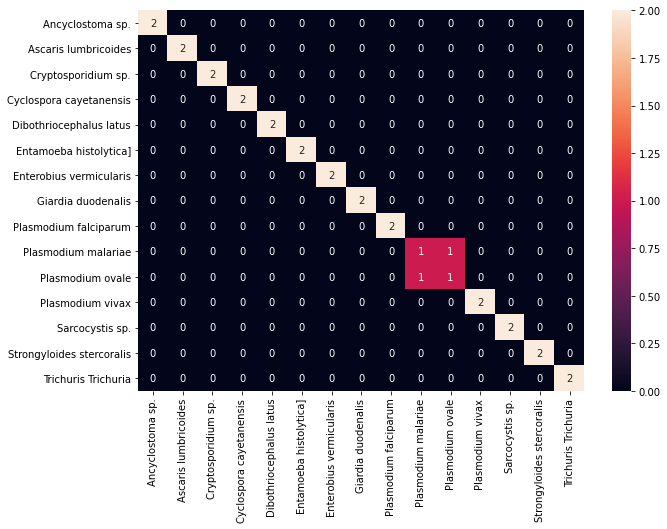

In [63]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = val_dataset.LE.classes_,
                  columns = val_dataset.LE.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()